In [1]:
import numpy as np
import pandas as pd

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.precision", 4)
sns.set()
seed = 0

In [2]:
# folder_path='D:\\Data Mining\\Homeworks\\HW1\\'
train_path = '24_train_1.csv'
test_path = 'news-test.csv'
dictionary_path = 'dictionary.txt'
train_df = pd.read_csv(train_path)
labels = train_df['Category'].unique().tolist()
test_df = pd.read_csv(test_path)
dictionary_words_list = pd.read_csv(dictionary_path, header=None)[0].tolist()


In [3]:
print("Number of Train samples = ", train_df.shape[0])
print("Number of Test samples = ", test_df.shape[0])
print("Dictionary size = ", len(dictionary_words_list))
print("Number of instances for each label:")
display(train_df[['ArticleId', 'Category']].groupby(by='Category').agg('count'))

Number of Train samples =  1000
Number of Test samples =  735
Dictionary size =  1000
Number of instances for each label:


,ArticleId
Category,
business,221
entertainment,178
politics,186
sport,231
tech,184


In [4]:
stemmer = PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    """
        Perform lowercase, punctuation and stopword removal, tokenization
        and finally stemming to get tokens from given text
    """
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation_map)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed

### PREPROCESSING DATA

In [5]:
tf = CountVectorizer(tokenizer=get_tokens, vocabulary=dictionary_words_list)
train_tf = tf.fit_transform(train_df['Text']).toarray()
test_tf = tf.transform(test_df['Text']).toarray()
print("done")
tfidf = TfidfVectorizer(tokenizer=get_tokens, vocabulary=dictionary_words_list)
train_tfidf = tfidf.fit_transform(train_df['Text']).toarray()
test_tfidf = tfidf.transform(test_df['Text']).toarray()

d:\Data Mining\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


done


In [6]:
k = 50
frequency = False
binarize = False
category_wise = True
sel_freq_mat = train_tfidf

# features = get_topk_words(sel_freq_mat, k, category_wise)
features = np.arange(len(dictionary_words_list))

train_matrix, test_matrix = train_tfidf, test_tfidf
    
X = train_matrix[:, features]
X_test = test_matrix[:, features]
y = train_df['Category']

### Funtions to perform K-Fold Cross Validation

In [7]:
def model_evaluator(X_train, y_train, clf_type, cv_param_name, cv_param_values, n_splits=5, init_params={}):
    """
        Perform K-Fold cross validation and collate
        results for each value, split combination
    """
    clf_type_dict={
        'Decision Tree': DecisionTreeClassifier(**init_params, random_state=seed),
        'Random Forest': RandomForestClassifier(**init_params, random_state=seed)
    }
    requested_clf=clf_type_dict[clf_type]

    eval_df = pd.DataFrame(columns=[cv_param_name, "Split Id", "Train Accuracy", "Validation Accuracy"])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for cv_param_val in cv_param_values:
        for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            requested_clf.set_params(**{cv_param_name: cv_param_val})
            requested_clf.fit(X_train[train_idx], y_train[train_idx])
            train_acc = accuracy_score(y_train[train_idx], requested_clf.predict(X_train[train_idx]))
            val_acc = accuracy_score(y_train[val_idx], requested_clf.predict(X_train[val_idx]))
            eval_df.loc[eval_df.shape[0]] = [cv_param_val, i, train_acc, val_acc]
    
    return eval_df

def plot_eval(eval_df, cv_param_name, clf_type, figsize=(8,5)):
    """
        Line plot for K-Fold cross validation results
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.lineplot(data=eval_df, x=cv_param_name, y='Train Accuracy', ax=ax, label="Train Accuracy")
    sns.lineplot(data=eval_df, x=cv_param_name, y='Validation Accuracy', ax=ax, label="Validation Accuracy")
    ax.set_ylabel("Accuracy")
    ax.set_title(clf_type + ": " + cv_param_name + " vs Accuracy")
    plt.show()

# 2. Decision Trees

### 2.1 Decision Tree Model

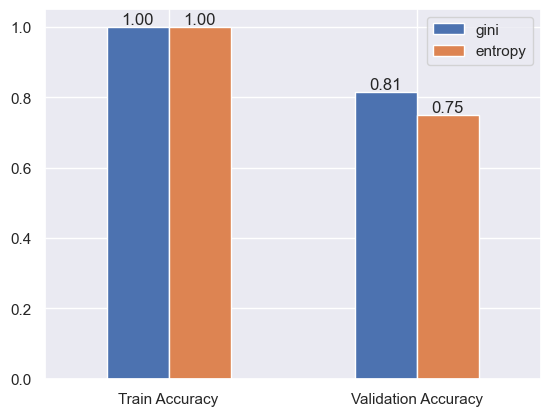

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
criterion = ['gini', 'entropy']
res = {c : [] for c in criterion}
for c in criterion:
    clf = DecisionTreeClassifier(criterion=c)
    clf.fit(X_train, y_train)
    res[c].append(accuracy_score(y_train, clf.predict(X_train)))
    res[c].append(accuracy_score(y_val, clf.predict(X_val)))
ax = pd.DataFrame(res, index=["Train Accuracy", "Validation Accuracy"]).plot.bar(rot=0)
_, _ = ax.bar_label(ax.containers[0], fmt="%.2f"), ax.bar_label(ax.containers[1], fmt="%.2f")

### 2.2. 5-fold cross validation for Decision Tree model for parameter min_samples_leaf

Train Accuracy         Validation Accuracy        
                           mean     std                mean     std
min_samples_leaf                                                   
1.0                      1.0000  0.0000               0.792  0.0144
10.0                     0.8752  0.0142               0.771  0.0319
20.0                     0.8102  0.0145               0.734  0.0219
30.0                     0.7838  0.0122               0.718  0.0144
40.0                     0.7452  0.0126               0.687  0.0351
50.0                     0.7282  0.0061               0.685  0.0296
60.0                     0.7103  0.0222               0.672  0.0385
70.0                     0.6660  0.0253               0.626  0.0331
80.0                     0.6410  0.0070               0.603  0.0172
90.0                     0.6255  0.0027               0.585  0.0334
100.0                    0.5963  0.0287               0.557  0.0428
110.0                    0.5385  0.0118               0.510  0.0300
120.0                    0.5302  0.0176               0.487  0.0329
130.0                    0.5157  0.0121               0.470  0.0209
140.0                    0.5112  0.0114               0.465  0.0339
150.0                    0.4895  0.0330               0.439  0.0313
160.0                    0.4508  0.0283               0.413  0.0553
170.0                    0.4360  0.0087               0.410  0.0281
180.0                    0.4325  0.0374               0.406  0.0438
190.0                    0.3725  0.0059               0.347  0.0160
200.0                    0.3730  0.0053               0.349  0.0152

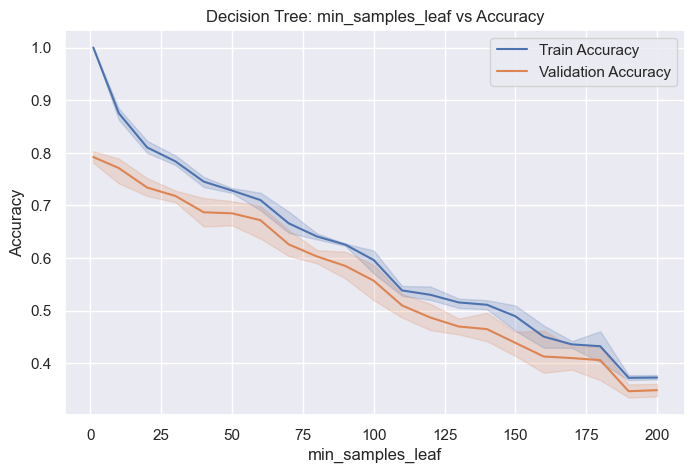

In [9]:
all_param={
    'model':"Decision Tree",
    'cv_param_name':"min_samples_leaf",
    'cv_param_values':10 * np.arange(0, 21, 1),
    'n_splits':5,
    'init_params':{}
}


all_param['cv_param_values'][0] = 1

eval_df = model_evaluator(X, y, all_param['model'], all_param['cv_param_name'], all_param['cv_param_values'], all_param['n_splits'], all_param['init_params'])

display(eval_df.groupby(all_param['cv_param_name']).agg(['mean', 'std']).drop("Split Id", axis=1))

plot_eval(eval_df, all_param['cv_param_name'], all_param['model'])

### 2.3. 5-fold cross validation for Decision Tree model for parameter max_features


Train Accuracy      Validation Accuracy        
                       mean  std                mean     std
max_features                                                
1.0                     1.0  0.0               0.505  0.0595
20.0                    1.0  0.0               0.698  0.0488
40.0                    1.0  0.0               0.698  0.0383
60.0                    1.0  0.0               0.757  0.0225
80.0                    1.0  0.0               0.761  0.0277
100.0                   1.0  0.0               0.765  0.0276
120.0                   1.0  0.0               0.761  0.0307
140.0                   1.0  0.0               0.764  0.0349
160.0                   1.0  0.0               0.779  0.0315
180.0                   1.0  0.0               0.795  0.0449
200.0                   1.0  0.0               0.785  0.0314
220.0                   1.0  0.0               0.750  0.0337
240.0                   1.0  0.0               0.798  0.0277
260.0                   1.0  0.0               0.801  0.0222
280.0                   1.0  0.0               0.758  0.0478
300.0                   1.0  0.0               0.774  0.0143
320.0                   1.0  0.0               0.766  0.0481
340.0                   1.0  0.0               0.772  0.0199
360.0                   1.0  0.0               0.779  0.0246
380.0                   1.0  0.0               0.801  0.0327
400.0                   1.0  0.0               0.790  0.0285

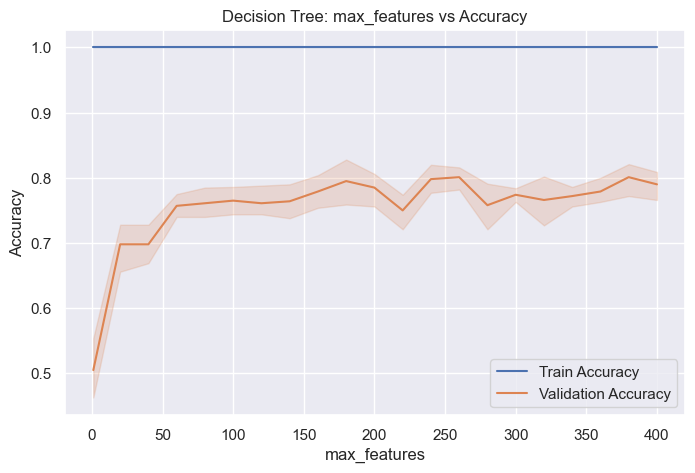

In [10]:
all_param={
    'model':"Decision Tree",
    'cv_param_name':"max_features",
    'cv_param_values':20 * np.arange(0, 21, 1),
    'n_splits':5,
    'init_params':{}
}


all_param['cv_param_values'][0] = 1

eval_df = model_evaluator(X, y, all_param['model'], all_param['cv_param_name'], all_param['cv_param_values'], all_param['n_splits'], all_param['init_params'])

display(eval_df.groupby(all_param['cv_param_name']).agg(['mean', 'std']).drop("Split Id", axis=1))

plot_eval(eval_df, all_param['cv_param_name'], all_param['model'])

# 3. Random Forest

## 3.1 Parameter Configuration for Random Forests

Utilizing the scikit-learn library, we adhere to the default parameter settings for our Random Forest models. The key hyperparameters available in this library and employed in our models are as follows:

- The criterion is set to ‘Gini’, which is used to measure the quality of a split.
- The min_samples_split is set to 2, indicating the minimum number of samples required to split an internal node.
- The n_estimators is initially set to 100, representing the number of trees in the forest. However, this parameter is subject to modifications in subsequent sections.
- The min_samples_leaf is initially set to 1, denoting the minimum number of samples required to be at a leaf node. Similar to n_estimators, this parameter is also adjusted in the following subsections.


These hyperparameters play a crucial role in the performance and accuracy of our Random Forest models. Modifications to these parameters are made based on specific requirements and optimizations in the subsequent sections of our analysis.


### 3.2. Evaluate 5-fold cross validation for Random Forest model for parameter `n_estimators`

Train Accuracy         Validation Accuracy        
                       mean     std                mean     std
n_estimators                                                   
1.0                  0.8795  0.0124               0.660  0.0557
10.0                 0.9995  0.0007               0.911  0.0171
20.0                 1.0000  0.0000               0.933  0.0172
30.0                 1.0000  0.0000               0.938  0.0189
40.0                 1.0000  0.0000               0.943  0.0168
50.0                 1.0000  0.0000               0.940  0.0177
60.0                 1.0000  0.0000               0.941  0.0198
70.0                 1.0000  0.0000               0.941  0.0185
80.0                 1.0000  0.0000               0.943  0.0160
90.0                 1.0000  0.0000               0.945  0.0173
100.0                1.0000  0.0000               0.946  0.0171

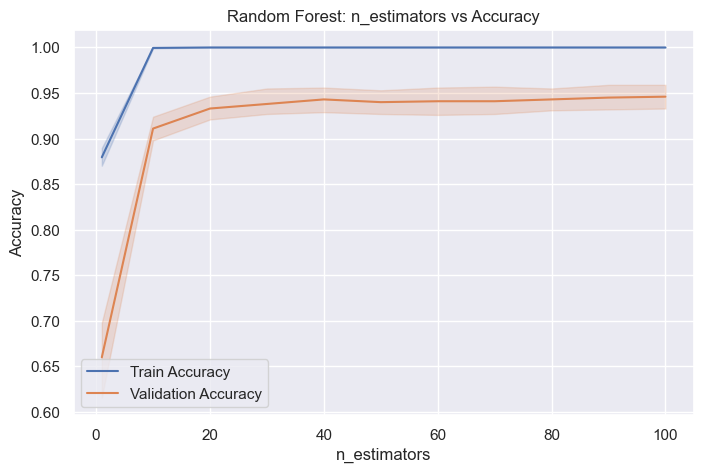

In [11]:
all_param={
    'model':"Random Forest",
    'cv_param_name':"n_estimators",
    'cv_param_values':10 * np.arange(0, 11, 1),
    'n_splits':5,
    'init_params':{}
}


all_param['cv_param_values'][0] = 1

eval_df = model_evaluator(X, y, all_param['model'], all_param['cv_param_name'], all_param['cv_param_values'], all_param['n_splits'], all_param['init_params'])

display(eval_df.groupby(all_param['cv_param_name']).agg(['mean', 'std']).drop("Split Id", axis=1))

plot_eval(eval_df, all_param['cv_param_name'], all_param['model'])

### 3.3. Evaluate 5-fold cross validation for Random Forest model for parameter `min_samples_leaf`

Train Accuracy         Validation Accuracy        
                           mean     std                mean     std
min_samples_leaf                                                   
1.0                      1.0000  0.0000               0.946  0.0171
10.0                     0.9655  0.0055               0.929  0.0195
20.0                     0.9420  0.0065               0.913  0.0246
30.0                     0.9283  0.0096               0.900  0.0281
40.0                     0.9042  0.0132               0.877  0.0317
50.0                     0.8722  0.0197               0.820  0.0366
60.0                     0.8090  0.0315               0.754  0.0356
70.0                     0.7300  0.0271               0.669  0.0518
80.0                     0.6715  0.0126               0.631  0.0519
90.0                     0.6190  0.0163               0.574  0.0301
100.0                    0.5585  0.0233               0.517  0.0434
110.0                    0.5075  0.0356               0.466  0.0572
120.0                    0.4245  0.0391               0.392  0.0577
130.0                    0.3720  0.0485               0.349  0.0671
140.0                    0.3315  0.0460               0.314  0.0679
150.0                    0.3060  0.0495               0.295  0.0694
160.0                    0.2955  0.0461               0.281  0.0594
170.0                    0.2878  0.0445               0.276  0.0636
180.0                    0.2777  0.0447               0.270  0.0609
190.0                    0.2675  0.0430               0.258  0.0550
200.0                    0.2605  0.0336               0.253  0.0425

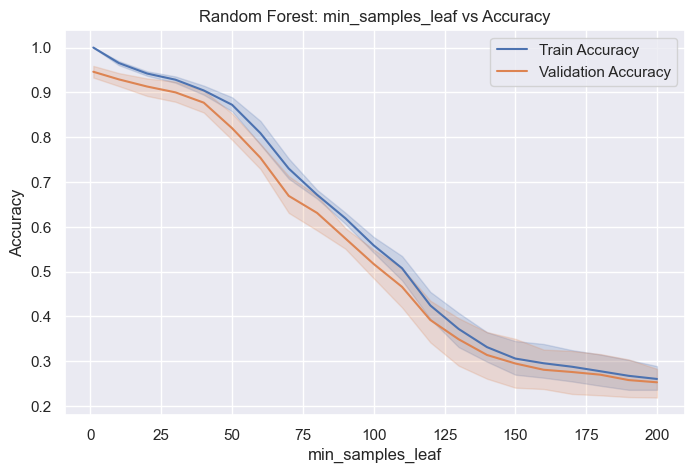

In [12]:



all_param={
    'model':"Random Forest",
    'cv_param_name':"min_samples_leaf",
    'cv_param_values':10 * np.arange(0, 21, 1),
    'n_splits':5,
    'init_params':{}
}

all_param['cv_param_values'][0] = 1

eval_df = model_evaluator(X, y, all_param['model'], all_param['cv_param_name'], all_param['cv_param_values'], all_param['n_splits'], all_param['init_params'])

display(eval_df.groupby(all_param['cv_param_name']).agg(['mean', 'std']).drop("Split Id", axis=1))

plot_eval(eval_df, all_param['cv_param_name'], all_param['model'])

In [13]:
def eval_gridsearch(X_train, y_train, base_clf, param_grid):
    clf_grid = GridSearchCV(
        estimator=base_clf,
        param_grid=param_grid,
        cv=5,
        scoring='f1_micro',
        n_jobs=8,
        refit=True,
        verbose=1
    )
    clf_grid.fit(X, y)

    return clf_grid

In [14]:
models = {
    'Decision Trees': {
        'model': DecisionTreeClassifier(criterion='gini', random_state=seed),
        'param_grid': {
            'min_samples_leaf': [1] + list(range(5,51,5)),
            'max_features': [10,20] + list(range(50,501,50))
        }
    },
    'Random Forests': {
        'model': RandomForestClassifier(criterion='gini', warm_start=True, random_state=seed),
        'param_grid': {
            'n_estimators': [10,50] + list(range(100,251,50)),
            'min_samples_leaf': [1] + list(range(5,51,5)),
        }
    },
    'AdaBoost Trees': {
        'model': AdaBoostClassifier(random_state=seed),
        'param_grid': {
            'estimator': [DecisionTreeClassifier(max_depth=1, random_state=seed),
                          DecisionTreeClassifier(max_depth=2, random_state=seed)],
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.5, 1.0, 2.0]
        }
    },
    'Gradient Boosting Trees': {
        'model': GradientBoostingClassifier(warm_start=True, random_state=seed),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.5, 1.0, 2.0],
        }
    }
}

In [15]:
for myModel in models.keys():
    print(f"Model Type: {myModel}")
    models[myModel]['clf_grid'] = eval_gridsearch(X, y, models[myModel]['model'], models[myModel]['param_grid'])
    print("Best Hyperparameters achieved: ", models[myModel]['clf_grid'].best_params_)
    print("F1-Micro Score = ", models[myModel]['clf_grid'].best_score_)
    print("+++++++++++++++++++++++++++++++++++++++++++")

Model Type: Decision Trees
Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best Hyperparameters achieved:  {'max_features': 500, 'min_samples_leaf': 1}
F1-Micro Score =  0.8100000000000002
+++++++++++++++++++++++++++++++++++++++++++
Model Type: Random Forests
Fitting 5 folds for each of 66 candidates, totalling 330 fits
Best Hyperparameters achieved:  {'min_samples_leaf': 1, 'n_estimators': 150}
F1-Micro Score =  0.9469999999999998
+++++++++++++++++++++++++++++++++++++++++++
Model Type: AdaBoost Trees
Fitting 5 folds for each of 24 candidates, totalling 120 fits


d:\Data Mining\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Hyperparameters achieved:  {'estimator': DecisionTreeClassifier(max_depth=2, random_state=0), 'learning_rate': 2.0, 'n_estimators': 300}
F1-Micro Score =  0.9349999999999999
+++++++++++++++++++++++++++++++++++++++++++
Model Type: Gradient Boosting Trees
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters achieved:  {'learning_rate': 0.5, 'n_estimators': 200}
F1-Micro Score =  0.95
+++++++++++++++++++++++++++++++++++++++++++


Best Model: Gradient Boosting Trees Best Score: 0.95
Accuracy =  1.0
               precision    recall  f1-score   support

     business       1.00      1.00      1.00       221
entertainment       1.00      1.00      1.00       178
     politics       1.00      1.00      1.00       186
        sport       1.00      1.00      1.00       231
         tech       1.00      1.00      1.00       184

     accuracy                           1.00      1000
    macro avg       1.00      1.00      1.00      1000
 weighted avg       1.00      1.00      1.00      1000



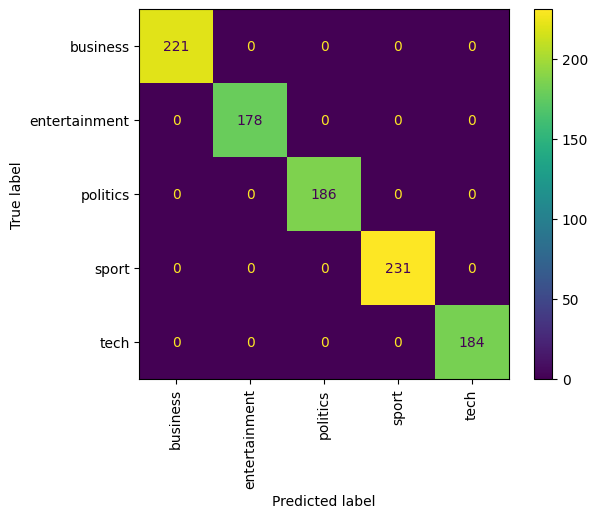

In [18]:
best_model, best_score = None, 0.0
best_model_name=None
for m in models.keys():
    if models[m]['clf_grid'].best_score_ > best_score:
        best_score = models[m]['clf_grid'].best_score_
        best_model = models[m]['clf_grid'].best_estimator_
        best_model_name=m
        
print(f'Best Model: {best_model_name} Best Score: {best_score}')
y_train_pred = best_model.predict(X)
print("Accuracy = ", accuracy_score(y, y_train_pred))
print(classification_report(y, y_train_pred))
sns.reset_orig()
_ = ConfusionMatrixDisplay.from_predictions(y, y_train_pred, xticks_rotation='vertical')
plt.show()

In [17]:
test_df['Prediction'] = best_model.predict(X_test)

test_df[['ArticleId', 'Prediction']].to_csv("labels.csv", header=False, index=False)